In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
from itertools import compress
filterwarnings('ignore')

NL shop

### Data loading, cleaning & formatting

In [7]:
data = pd.read_csv('nl_shop_orders_sp_cross_selling.dsv', sep=';', low_memory=False)

In [8]:
data.sample(5)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_KO_COUNT_NET,OSP_3_LEAD_P_PG_ID,OSP_3_LEAD_P_PG_SHARE,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE
1808570,454038939,106483495,12/03/2018 00:00,21:36,7,12078518,"45,99","5,2883","0,2383","38,0083",...,10,252.0,1,683.0,1,NaN,NaN,NaN,NaN,NaN
1882732,469426294,110222910,07/05/2018 00:00,22:20,7,14104380,"-0,99","-0,8182","-0,8182","-0,8182",...,35,29.0,1,128.0,"0,8487",22/03/2018 00:00,22/03/2019 00:00,51.0,3.0,"2,99"
960459,312229940,73624875,28/08/2016 00:00,21:40,7,13410890,"57,99","17,5656","14,0862","47,9256",...,8,251.0,"0,5919",18245.0,"0,5919",10/03/2016 09:20,10/03/2017 23:59,56.0,5.0,"4,9"
393635,270504659,63982903,01/02/2016 00:00,10:28,7,13413125,"14,99","3,7984","1,3892","12,3884",...,1,252.0,"0,5161",683.0,"0,5161",NaN,NaN,NaN,NaN,NaN
2288440,257145328,60942649,26/11/2015 00:00,10:21,7,12455587,"-3,57","-2,9504","-2,9504","-2,9504",...,8,301.0,"0,481",152946.0,"0,481",05/10/2015 03:31,05/10/2016 23:59,56.0,5.0,"4,9"


In [9]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260104 entries, 0 to 3260103
Data columns (total 23 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              float64
OSP_3_LEAD_P_PG_SHARE           object
OSP_4_LEAD_P_PG_ID              float64
OSP_4_LEAD_P_PG_SHARE           object
CZP_START_DATE                  object
CZP_EXPIRY_DATE                 object
CZP_ZTQ_ID                      float64
CZP_PERCENTAGE                  float64
CZP_PRICE                       o

In [10]:
def get_date(x):
    return x.split(' ')[0]

In [11]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [12]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format='%d/%m/%Y')

In [13]:
data['ORDER_DATETIME'] = data['TDT_T_KEY_ORDER_DATE'].astype(str) + ' ' + data['THR_C_KEY_ORDER_HOUR'].astype(str) + ':00'

In [14]:
data['ORDER_DATETIME'] = pd.to_datetime(data['ORDER_DATETIME'], format="%Y-%m-%d %H:%M:%S")

In [15]:
data['CZP_START_DATE'] = pd.to_datetime(data['CZP_START_DATE'], format="%d/%m/%Y %H:%M")
data['CZP_EXPIRY_DATE'] = pd.to_datetime(data['CZP_EXPIRY_DATE'], format="%d/%m/%Y %H:%M")

In [16]:
data['SCM_SALES_BMF'] = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_D_FINANCE_CM1'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM2'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]

In [17]:
data['CZP_PRICE'] = [float(str(i).replace(',','.')) for i in data['CZP_PRICE'].values]
data['OSP_3_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_3_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]

In [18]:
#boolean mask with duplicated orders due to SP as True
dupl_mask = [len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values]

In [19]:
#get duplicated order IDs
dup_orders = data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique()[dupl_mask].index.values

In [20]:
len(dup_orders)

4971

In [21]:
sp_acq_dup_orders = list(data[data['SCM_N_ORDER_NR'].isin(dup_orders)][data[data['SCM_N_ORDER_NR'].isin(dup_orders)]['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique())
len(sp_acq_dup_orders)

4958

In [22]:
no_sp_acq_dup_orders = [i for i in dup_orders if i not in sp_acq_dup_orders]
len(no_sp_acq_dup_orders)

13

In [23]:
#Let's get incorrect duplicated indexes instead of order_id to exclude them and select the correct data subset
dup_indexes = []

for i in sp_acq_dup_orders:
    o_id = data[data['SCM_N_ORDER_NR'] == i]
    old_sp_date = min(o_id['CZP_START_DATE'])
    old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
    dup_indexes.append(old_sp_index)

In [24]:
len(dup_indexes)

4958

In [28]:
for i in no_sp_acq_dup_orders:
    c_id = data[data['SCM_N_ORDER_NR'] == i]['CUS_N_KEY_CUSTOMER'].unique()[0]
    cust_orders = data[data['CUS_N_KEY_CUSTOMER'] == c_id]
    sp_order = cust_orders[cust_orders['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique()[0]
    if i < sp_order:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        new_non_valid_sp_date = max(o_id['CZP_START_DATE'])
        new_sp_index = o_id[o_id['CZP_START_DATE'] == new_non_valid_sp_date].index.values
        dup_indexes.append(new_sp_index)
    else:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        old_sp_date = min(o_id['CZP_START_DATE'])
        old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
        dup_indexes.append(old_sp_index)

In [29]:
len(dup_indexes)

4971

In [30]:
#Get a flatten list of indexes
dupl_ind = [i for lista in dup_indexes for i in lista]

print('Duplicated rows detected: ', len(dupl_ind))
print('Start dropping..')

#Drop duplicated indexes
data.drop(dupl_ind, inplace=True)

#0 printed, in order to be sure there are no orders duplicated remaining...
print('Number of order IDs having more than one SP_START_DATE now: ',
      sum(len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values))

Duplicated rows detected:  31447
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [31]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [32]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [33]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [34]:
data['MAX_SALES_O_POS'] = data['SCM_SALES_BMF'].groupby(data['SCM_N_ORDER_NR']).transform('max')
data['IS_LEAD_AS'] = (data['SCM_SALES_BMF'] == data['MAX_SALES_O_POS']) * 1 * data['SCM_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['SCM_N_ORDER_NR']).transform('max')

In [35]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [36]:
#Get brands per PG4
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [37]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [38]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
PPR_N_LEVEL4_ID      2006 non-null int64
PPR_V_LEVEL4_DESC    2006 non-null object
BRAND                2006 non-null object
dtypes: int64(1), object(2)
memory usage: 47.1+ KB


In [39]:
brands.sample(10)

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
455,83300,83300 - Orijen,Orijen
392,71036,71036 - Hufschutz,Hufschutz
1710,257388,257388 - Shampoo & Duschgel,Shampoo & Duschgel
980,225917,225917 - Alpha Spirit,Alpha Spirit
1943,72013,72013 - mit Milch & Käse,mit Milch & Käse
1886,65150,65150 - Gebisslose Zäumung,Gebisslose Zäumung
1110,525,525 - Durchlüfter/-ersatzteile,Durchlüfter/-ersatzteile
1546,1161,1161 - Aktionen Vogel,Aktionen Vogel
215,243929,243929 - Monge,Monge
144,15887,15887 - Marstall,Marstall


In [40]:
#Get physical articles with their PG structure
ap_pg = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [41]:
ap_pg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 9 columns):
AP_ID       62994 non-null int64
PP_ID       62994 non-null int64
L1_PG_ID    62994 non-null int64
L2_PG_ID    62993 non-null float64
L3_PG_ID    62537 non-null float64
L4_PG_ID    60229 non-null float64
L5_PG_ID    29125 non-null float64
L6_PG_ID    18 non-null float64
L7_PG_ID    0 non-null float64
dtypes: float64(6), int64(3)
memory usage: 4.3 MB


In [42]:
ap_pg = ap_pg[['AP_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

In [43]:
ap_pg.sample(10)

,AP_ID,L3_PG_ID,L4_PG_ID
59673,65062,20,108
3082,24227,18,16330
26436,21017,68,1657
4393,41914,48652,0
59952,62196,9788,9789
59868,48595,23,2060
4962,65429,1540,1555
43406,33629,252,1520
37534,74716,34,1559
25271,12318,251,719


In [44]:
#Merge both tables to add the brand for each AP_ID
ap_pg_brand = pd.merge(ap_pg, brands, how='left', left_on='L4_PG_ID', right_on='PPR_N_LEVEL4_ID')

In [45]:
ap_pg_brand.sample(20)

,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
48713,11159,820,823,823,823 - JBL,JBL
22875,82549,251,128993,128993,128993 - Advance Veterinary Diets,Advance Veterinary Diets
19680,33326,23,1546,1546,1546 - aus Echt- & Vollholz,aus Echt- & Vollholz
19750,35652,65,4896,4896,4896 - DENNERLE Pflanzen,DENNERLE Pflanzen
25898,16961,3156,0,0,*NOT DEFINED,unknown
33389,13675,221,54,54,54 - Wellensittichfutter,Wellensittichfutter
56517,10511,29,128,128,128 - Haubentoiletten,Haubentoiletten
53067,50907,1540,1555,1555,1555 - Katzenhöhlen,Katzenhöhlen
4146,37892,1603,20749,20749,20749 - Kunststoffspielzeug,Kunststoffspielzeug
54748,76081,18,201276,201276,201276 - Alle Hundesnacks,Alle Hundesnacks


In [46]:
data = pd.merge(data, ap_pg_brand, how='left', left_on='SCM_AP_ID', right_on='AP_ID')

In [47]:
data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']] = data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']].fillna(0).astype(int)

In [48]:
data.sample(10)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,D84,D168,D252,D336,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
1181561,343106047,80646990,2017-01-11,11:32,7,12015131,7.99,2.3133,1.6988,6.6033,...,2015-10-07,2015-12-30,2016-03-23,2016-06-15,63098,18,101,101,101 - Kauknochen & Kaurollen,Kauknochen & Kaurollen
1518807,393865989,92245748,2017-08-09,12:45,7,12138696,1.99,1.2446,-3.2747,1.6446,...,2015-10-27,2016-01-19,2016-04-12,2016-07-05,17488,29,118,118,118 - Bürsten & Kämme,Bürsten & Kämme
2846744,286710168,67747848,2016-04-24,13:11,7,13036454,17.98,6.6995,2.0111,14.8595,...,2016-03-06,2016-05-29,2016-08-21,2016-11-13,6597,301,304,304,304 - Cat's Best,Cat's Best
1679739,425237701,99689601,2017-12-03,13:28,7,14161938,35.98,7.6555,3.0389,29.7355,...,2016-08-01,2016-10-24,2017-01-16,2017-04-10,61268,2068,17963,17963,17963 - Royal Canin,Royal Canin
2903175,289615766,68421290,2016-05-09,00:47,7,14111701,51.99,7.8469,3.1442,42.9669,...,2016-07-25,2016-10-17,2017-01-09,2017-04-03,61312,252,261925,261925,261925 - Royal Canin Rasse (Breed),Royal Canin Rasse (Breed)
2983503,377294938,88441597,2017-06-05,11:53,7,13354296,16.99,5.3013,4.2226,14.0413,...,2016-04-17,2016-07-10,2016-10-02,2016-12-25,26664,252,23302,23302,23302 - Applaws,Applaws
2415739,367317462,86137549,2017-04-24,09:27,7,14210644,-2.46,-2.0331,-2.0331,-2.0331,...,2016-08-07,2016-10-30,2017-01-22,2017-04-16,0,0,0,0,NaN,NaN
2387994,263198200,62276704,2015-12-23,18:36,7,12242958,5.99,1.9304,1.4553,4.9504,...,2015-11-14,2016-02-06,2016-04-30,2016-07-23,53903,20,465,465,465 - KONG,KONG
3091804,353041088,82921225,2017-02-22,18:26,7,13482681,0.00,0.0000,0.0000,0.0000,...,2016-05-03,2016-07-26,2016-10-18,2017-01-10,0,0,0,0,NaN,NaN
2711040,419004093,98229749,2017-11-12,17:48,7,12666065,-13.00,-10.7438,-10.7438,-10.7438,...,2016-01-26,2016-04-19,2016-07-12,2016-10-04,0,0,0,0,NaN,NaN


In [49]:
data.loc[2359877]

SCM_N_ORDER_POS_NR                           362622352
SCM_N_ORDER_NR                                85093600
TDT_T_KEY_ORDER_DATE               2017-04-03 00:00:00
THR_C_KEY_ORDER_HOUR                             21:59
SIT_N_KEY_SITE                                       7
CUS_N_KEY_CUSTOMER                             8642630
SCM_SALES_BMF                                        0
SCM_D_FINANCE_CM1                                -0.76
SCM_D_FINANCE_CM2                              -1.1033
SCM_D_ORIG_FINANCE_ORDER_NET                         0
SCM_AP_ID                                        23797
SCM_AS_ID                                       464733
SCM_MASTER_AP_ID                                 23797
OSP_KO_COUNT_NET                                    11
OSP_3_LEAD_P_PG_ID                                 252
OSP_3_LEAD_P_PG_SHARE                            0.838
OSP_4_LEAD_P_PG_ID                              261925
OSP_4_LEAD_P_PG_SHARE                            0.838
CZP_START_

In [50]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'MAX_SALES_O_POS', 'IS_LEAD_AS', 'LEAD_AS_ID', 'D28',
       'D56', 'D84', 'D168', 'D252', 'D336', 'AP_ID', 'L3_PG_ID', 'L4_PG_ID',
       'PPR_N_LEVEL4_ID', 'PPR_V_LEVEL4_DESC', 'BRAND'],
      dtype='object')

In [51]:
#data.to_pickle("./orders_nl_shop_sp_cross_selling.pkl")

### Order level

In [2]:
data = pd.read_pickle("./orders_nl_shop_sp_cross_selling.pkl")

In [52]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'SCM_AP_ID': lambda x: list(x),
          'L4_PG_ID': lambda x: list(x),
          'BRAND': lambda x: list(x),
          'PPR_V_LEVEL4_DESC': lambda x: list(x),
          'L3_PG_ID': lambda x: list(x),
          'SCM_AS_ID': lambda x: list(x),
          'LEAD_AS_ID': max,
          'SCM_MASTER_AP_ID': lambda x: list(x),
          'CZP_ZTQ_ID': min, 
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [53]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [54]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [55]:
orders.columns = ['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET',
       'OSP_KO_COUNT_NET', 'SCM_AP_ID_list', 'L4_PG_ID_list',
       'BRAND_list', 'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list',
       'SCM_AS_ID_list', 'LEAD_AS_ID', 'SCM_MASTER_AP_ID_list',
       'CZP_ZTQ_ID', 'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168',
       'D252', 'D336']

In [73]:
orders['SP_PURCHASE'] = [42225 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [74]:
orders['SP_PURCHASE'].value_counts()

False    796816
True      44255
Name: SP_PURCHASE, dtype: int64

In [75]:
orders['SP_DISC'] = [42715 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [76]:
orders['SP_DISC'].value_counts()

False    583114
True     257957
Name: SP_DISC, dtype: int64

We need to calculate, for each order, sales per PG3/PG4/BRAND... 

In [77]:
orders['PG3_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L3_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [78]:
orders['PG4_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L4_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [79]:
orders['BRAND_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['BRAND_list'], 
                                                                                   orders['SCM_SALES_BMF_list']))]

In [80]:
orders['PG3_AGGSALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG3_SALES']]

In [81]:
orders['PG4_AGGSALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                        for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG4_SALES']]

In [82]:
orders['BRAND_AGGSALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                        for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['BRAND_SALES']]

In [83]:
orders.sample(10)[['SCM_SALES_BMF_list', 'SCM_AP_ID_list', 'SP_DISC', 'L3_PG_ID_list', 'PG3_SALES', 'PG3_AGGSALES', 
                   'L4_PG_ID_list', 'PG4_SALES', 'PG4_AGGSALES', 'BRAND_list', 'BRAND_SALES', 'BRAND_AGGSALES']]

,SCM_SALES_BMF_list,SCM_AP_ID_list,SP_DISC,L3_PG_ID_list,PG3_SALES,PG3_AGGSALES,L4_PG_ID_list,PG4_SALES,PG4_AGGSALES,BRAND_list,BRAND_SALES,BRAND_AGGSALES
312195,"[41.49, -3.87, 1.99, 33.98]","[52564, 0, 64698, 61272]",True,"[252, 0, 36, 2068]","[(252, 41.49), (0, -3.87), (36, 1.99), (2068, ...","[(252, 41.49), (2068, 33.98), (36, 1.99), (0, ...","[81397, 0, 679, 17963]","[(81397, 41.49), (0, -3.87), (679, 1.99), (179...","[(81397, 41.49), (17963, 33.98), (679, 1.99), ...","[Royal Canin Veterinary Diet, nan, Mäuse & Bäl...","[(Royal Canin Veterinary Diet, 41.49), (nan, -...","[(Royal Canin Veterinary Diet, 41.49), (Royal ..."
835519,"[-1.77, 0.0, 34.99, 0.0, 6.02, 5.79, 6.3, 5.88]","[0, 52417, 71113, 37447, 24985, 26231, 33650, ...",True,"[0, 34, 252, 18, 857, 857, 857, 857]","[(0, -1.77), (34, 0.0), (252, 34.99), (18, 0.0...","[(252, 34.99), (857, 23.99), (34, 0.0), (18, 0...","[0, 71978, 42545, 104, 17198, 17198, 17198, 17...","[(0, -1.77), (71978, 0.0), (42545, 34.99), (10...","[(42545, 34.99), (17198, 23.99), (104, 0.0), (...","[nan, Knuspersnacks, Purina ONE, vom Rind, Her...","[(nan, -1.77), (Knuspersnacks, 0.0), (Purina O...","[(Purina ONE, 34.99), (Herrmann's, 23.99), (na..."
251509,"[9.15, 45.99, -5.51]","[64487, 61197, 0]",False,"[2068, 252, 0]","[(2068, 9.15), (252, 45.99), (0, -5.51)]","[(252, 45.99), (2068, 9.15), (0, -5.51)]","[2127, 683, 0]","[(2127, 9.15), (683, 45.99), (0, -5.51)]","[(683, 45.99), (2127, 9.15), (0, -5.51)]","[Almo Nature, Royal Canin, nan]","[(Almo Nature, 9.15), (Royal Canin, 45.99), (n...","[(Royal Canin, 45.99), (Almo Nature, 9.15), (n..."
522346,"[28.99, 49.99, 33.49, 0.0]","[33729, 38566, 57452, 69730]",False,"[252, 251, 252, 252]","[(252, 28.99), (251, 49.99), (252, 33.49), (25...","[(252, 62.48), (251, 49.99)]","[720, 17798, 81397, 201878]","[(720, 28.99), (17798, 49.99), (81397, 33.49),...","[(17798, 49.99), (81397, 33.49), (720, 28.99),...","[Hill's Science Plan, Royal Canin Breed (Rasse...","[(Hill's Science Plan, 28.99), (Royal Canin Br...","[(Royal Canin Breed (Rasse), 49.99), (Royal Ca..."
588789,"[52.0, 52.0, -3.12]","[74727, 74727, 0]",True,"[251, 251, 0]","[(251, 52.0), (251, 52.0), (0, -3.12)]","[(251, 104.0), (0, -3.12)]","[754, 754, 0]","[(754, 52.0), (754, 52.0), (0, -3.12)]","[(754, 104.0), (0, -3.12)]","[Nutro, Nutro, nan]","[(Nutro, 52.0), (Nutro, 52.0), (nan, -3.12)]","[(Nutro, 104.0), (nan, 0)]"
528579,"[24.99, 20.99, 5.99, 81.99]","[68059, 37446, 63782, 61383]",False,"[2068, 18, 18, 251]","[(2068, 24.99), (18, 20.99), (18, 5.99), (251,...","[(251, 81.99), (18, 26.98), (2068, 24.99)]","[2071, 104, 1438, 255]","[(2071, 24.99), (104, 20.99), (1438, 5.99), (2...","[(255, 81.99), (2071, 24.99), (104, 20.99), (1...","[Felix, vom Rind, vom Lamm, Eukanuba]","[(Felix, 24.99), (vom Rind, 20.99), (vom Lamm,...","[(Eukanuba, 81.99), (Felix, 24.99), (vom Rind,..."
483098,"[9.99, 5.59, 5.99, 5.99, 5.59, 5.0, 5.0, 4.49,...","[50892, 50302, 57006, 57007, 50303, 69003, 689...",False,"[2068, 2068, 2068, 2068, 2068, 2068, 2068, 252...","[(2068, 9.99), (2068, 5.59), (2068, 5.99), (20...","[(2068, 43.15), (252, 10.59)]","[2072, 2072, 11751, 11751, 2072, 2072, 2072, 6...","[(2072, 9.99), (2072, 5.59), (11751, 5.99), (1...","[(2072, 31.17), (11751, 11.98), (42545, 6.1), ...","[Gourmet Gold, Gourmet Gold, Applaws, Applaws,...","[(Gourmet Gold, 9.99), (Gourmet Gold, 5.59), (...","[(Gourmet Gold, 31.17), (Applaws, 11.98), (Pur..."
334490,"[33.98, 9.99, 49.99]","[61276, 60801, 67374]",False,"[2068, 2068, 252]","[(2068, 33.98), (2068, 9.99), (252, 49.99)]","[(252, 49.99), (2068, 43.97)]","[17963, 17963, 81397]","[(17963, 33.98), (17963, 9.99), (81397, 49.99)]","[(81397, 49.99), (17963, 43.97)]","[Royal Canin, Royal Canin, Royal Canin Veterin...","[(Royal Canin, 33.98), (Royal Canin, 9.99), (R...","[(Royal Canin Veterinary Diet, 49.99), (Royal ..."
362311,"[-1.5, 29.99, 2.99]","[0, 67610, 0]",True,"[0, 29, 0]","[(0, -1.5), (29, 29.99), (0, 2.99)]","[(29, 29.99), (0, 1.49)]","[0, 35032, 0]","[(0, 

In [84]:
#orders.to_pickle("./one_year_aggregated_orders_nl_shop_sp_cross_selling.pkl")

### Customer level

In [ ]:
orders = pd.read_pickle("./one_year_aggregated_orders_nl_shop_sp_cross_selling.pkl")

In [85]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET',
       'SCM_AP_ID_list', 'L4_PG_ID_list', 'BRAND_list',
       'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list', 'SCM_AS_ID_list',
       'LEAD_AS_ID', 'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336',
       'SP_PURCHASE', 'SP_DISC', 'PG3_SALES', 'PG4_SALES', 'BRAND_SALES',
       'PG3_AGGSALES', 'PG4_AGGSALES', 'BRAND_AGGSALES'],
      dtype='object')

In [86]:
agg_ord_ops = {
              'SCM_N_ORDER_NR': len,
              'TDT_T_KEY_ORDER_DATE': lambda x: list(x.dt.date),
              'SCM_SALES_BMF_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'SCM_MASTER_AP_ID_list': lambda x: list(x),
              'CZP_ZTQ_ID': lambda x: list(set(list(x))),
              'CZP_START_DATE': lambda x: list(set(list(x.dt.date))),
              'CZP_EXPIRY_DATE': lambda x: list(set(list(x.dt.date))),
              'PG3_AGGSALES': lambda x: list(x),
              'PG4_AGGSALES': lambda x: list(x),
              'BRAND_AGGSALES': lambda x: list(x),
              'SP_PURCHASE': lambda x: list(x),
              'SP_DISC': lambda x: list(x),
              'D28': max,
              'D56': max,
              'D84': max,
              'D168': max,
              'D252': max,
              'D336': max
              }

In [87]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [88]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [89]:
customers.columns = ['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len',
       'TDT_T_KEY_ORDER_DATE_list', 'SCM_SALES_BMF_sum',
       'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES', 'SP_PURCHASE', 'SP_DISC', 'D28', 'D56', 'D84', 'D168',
       'D252', 'D336']

In [90]:
customers['O_TIMEDELTAS'] = [[(i - j).days for i, j in list(zip(o_list[1:], o_list[:-1]))] 
                             for o_list in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [91]:
customers['FLAT_PG3_SALES'] = [[k for j in i for k in j] for i in customers['PG3_AGGSALES'].values]

In [92]:
customers['FLAT_PG4_SALES'] = [[k for j in i for k in j] for i in customers['PG4_AGGSALES'].values]

In [93]:
customers['FLAT_BRAND_SALES'] = [[k for j in i for k in j] for i in customers['BRAND_AGGSALES'].values]

In [94]:
customers['TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG3_SALES']]

In [95]:
customers['TOTAL_PG4_SALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                                for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG4_SALES']]

In [96]:
customers['TOTAL_BRAND_SALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_BRAND_SALES']]

In [97]:
#customers.to_pickle("./customers_nl_shop_sp_cross_selling.pkl")

In [98]:
del customers['FLAT_PG3_SALES']

In [99]:
del customers['FLAT_PG4_SALES']

In [100]:
del customers['FLAT_BRAND_SALES']

### Framework

***BRAND SPECIFIC SP ANALYSIS***

In [2]:
customers = pd.read_pickle("./customers_nl_shop_sp_cross_selling.pkl")

In [3]:
customers.head(10)[customers.columns[:11]]

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,SCM_D_ORIG_FINANCE_ORDER_NET_list
0,1024867,8,"[2017-04-12, 2017-05-13, 2017-06-09, 2017-08-1...",525.76,"[121.09, 51.97, 69.87, 63.26, 55.07, 45.98, 68...",162.18,"[39.8, 20.13, 23.27, 19.58, 13.47, 12.66, 18.2...",111.47,"[28.36, 14.74, 17.65, 14.26, 8.28, 5.76, 13.41...",434.51,"[100.07, 42.95, 57.74, 52.28, 45.51, 38.0, 56...."
1,1119747,2,"[2015-10-08, 2016-05-24]",76.92,"[37.95, 38.97]",29.55,"[15.47, 14.08]",18.89,"[9.99, 8.9]",63.57,"[31.36, 32.21]"
2,1139016,5,"[2016-06-14, 2017-04-19, 2017-05-18, 2017-09-2...",580.50,"[161.43, 116.13, 97.98, 169.97, 34.99]",192.00,"[56.49, 38.07, 41.67, 44.94, 10.84]",144.80,"[42.39, 26.14, 36.04, 34.26, 5.97]",479.75,"[133.41, 95.98, 80.98, 140.47, 28.92]"
3,1158470,3,"[2016-02-14, 2016-10-01, 2017-01-22]",119.14,"[56.16, 40.0, 22.98]",41.26,"[15.55, 14.03, 11.68]",23.21,"[8.34, 8.15, 6.72]",98.46,"[46.41, 33.06, 18.99]"
4,1170395,2,"[2016-04-06, 2016-05-12]",72.97,"[22.98, 49.99]",29.36,"[10.17, 19.18]",17.52,"[5.01, 12.5]",60.31,"[18.99, 41.31]"
5,1170897,5,"[2016-06-15, 2016-09-12, 2017-01-30, 2017-08-1...",171.34,"[19.42, 37.98, 37.98, 37.98, 37.98]",40.70,"[4.47, 8.19, 8.23, 9.91, 9.91]",-7.32,"[-1.1, -2.95, -2.21, -0.53, -0.53]",141.60,"[16.05, 31.39, 31.39, 31.39, 31.39]"
6,1218191,1,[2016-03-15],17.47,[17.47],8.70,[8.7],3.63,[3.63],14.44,[14.44]
7,1262239,14,"[2016-03-02, 2016-04-20, 2016-07-24, 2016-11-2...",841.81,"[62.15, 103.78, 103.78, 56.25, 54.3, 51.4, 53....",159.80,"[15.76, 18.19, 18.61, 14.3, 11.95, 8.71, 7.01,...",60.85,"[8.87, 5.59, 6.01, 8.0, 5.36, 2.13, -0.36, 3.3...",695.71,"[51.36, 85.77, 85.77, 46.49, 44.88, 42.48, 44...."
8,1361081,2,"[2015-12-14, 2016-01-29]",99.68,"[49.89, 49.79]",12.92,"[8.2, 4.72]",1.25,"[2.11, -0.86]",82.38,"[41.23, 41.15]"
9,1372538,7,"[2016-02-15, 2016-02-29, 2016-05-25, 2016-07-2...",212.25,"[18.98, 32.98, 18.98, 35.97, 32.98, 32.98, 39.38]",64.13,"[6.56, 9.0, 6.58, 9.48, 9.14, 9.14, 14.26]",25.72,"[1.49, 3.88, -0.25, 4.01, 4.01, 4.01, 8.56]",175.41,"[15.69, 27.26, 15.69, 29.73, 27.26, 27.26, 32.55]"


In [4]:
customers.head(10)[customers.columns[11:20]]

,OSP_KO_COUNT_NET_list,SCM_MASTER_AP_ID_list,CZP_ZTQ_ID,CZP_START_DATE,CZP_EXPIRY_DATE,PG3_AGGSALES,PG4_AGGSALES,BRAND_AGGSALES,SP_PURCHASE
0,"[1, 2, 3, 4, 5, 6, 7, 8]","[[60605, 45361, 68204, 65466, 65466, 71502, 52...","[nan, nan, 53.0, nan]","[nan, 2017-08-10]","[nan, 2018-08-10]","[[(23, 75.99), (2068, 41.99), (252, 3.11)], [(...","[[(49727, 75.99), (2632, 18.86), (2074, 16.14)...","[[(Kratztonnen, 75.99), (★ Cosma, 18.86), (Iam...","[False, False, False, True, False, False, Fals..."
1,"[1, 2]","[[15149, 66279, 53903, 35837, 51227], [67420, ...","[nan, nan]",[nan],[nan],"[[(20, 19.96), (15, 17.99)], [(15, 29.99), (20...","[[(16637, 17.99), (465, 13.98), (96500, 3.49),...","[[(Schleppleine & Feldleine, 17.99), (KONG, 13...","[False, False]"
2,"[1, 2, 3, 4, 5]","[[62058, 54201, 64916, 19608, 62710, 68333], [...","[nan, nan, nan, nan, nan]",[nan],[nan],"[[(252, 84.99), (36, 37.46), (221, 28.99), (98...","[[(35824, 84.99), (1343, 28.99), (136, 21.47),...","[[(Taste of the Wild, 84.99), (Papageienfutter...","[False, False, False, False, False]"
3,"[1, 2, 3]","[[27430, 6169, 28021, 37549], [28066, 28026, 2...","[nan, nan, nan]",[nan],[nan],"[[(9, 34.99), (857, 21.64), (18, 2.49), (0, -2...","[[(30936, 34.99), (6530, 21.64), (104, 2.49), ...","[[(Gesundheitsbetten, 34.99), (★ Rocco, 21.64)...","[False, False, False]"
4,"[1, 2]","[[6168, 64466], [68240]]","[nan, nan]",[nan],[nan],"[[(9, 19.99), (0, 2.99)], [(23, 49.99)]]","[[(97768, 19.99), (0, 2.99)], [(49727, 49.99)]]","[[(Hundebetten, 19.99), (nan, 0)], [(Kratztonn...","[False, False]"
5,"[1, 2, 3, 4, 5]","[[6168, 6169, 67186], [67186, 67186], [67186, ...","[nan, nan, nan, nan, nan]",[nan],[nan],"[[(301, 17.29), (0, 2.13)], [(301, 37.98)], [(...","[[(302, 17.29), (0, 2.13)], [(302, 37.98)], [(...","[[(Catsan, 17.29), (nan, 0)], [(Catsan, 37.98)...","[False, False, False, False, False]"
6,[1],"[[37868, 12458, 6168]]",[nan],[nan],[nan],"[[(409, 7.99), (401, 6.49), (0, 2.99)]]","[[(2230, 7.99), (1084, 6.49), (0, 2.99)]]","[[(Schermaschinen, 7.99), (Kräcker & Gebacken...",[False]
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[[61100, 5482, 42715, 42225, 26911], [42715, 6...","[51.0, 55.0]","[2017-01-23, 2018-04-03, 2016-03-02]","[2018-03-02, 2017-01-23, 2019-04-03]","[[(251, 57.99), (18, 4.49), (48963, 2.9), (0, ...","[[(682, 57.99), (1441, 4.49), (0, -0.33)], [(6...","[[(Royal Canin Size, 57.99), (Fleischstreifen ...","[True, False, False, False, True, False, False..."
8,"[1, 2]","[[30306], [61072, 61072]]","[nan, nan]",[nan],[nan],"[[(251, 49.89)], [(251, 47.93), (9, 1.86)]]","[[(682, 49.89)], [(682, 47.93), (74, 1.86)]]","[[(Royal Canin Size, 49.89)], [(Royal Canin Si...","[False, False]"
9,"[1, 2, 3, 4, 5, 6, 7]","[[66053, 6168], [6168, 66053], [66053, 6168], ...","[nan, nan, nan, nan, nan, nan, 53.0]","[nan, 2016-10-12]","[nan, 2017-10-12]","[[(251, 15.99), (0, 2.99)], [(251, 29.99), (0,...","[[(283, 15.99), (0, 2.99)], [(283, 29.99), (0,...","[[(Pro Plan, 15.99), (nan, 0)], [(Pro Plan, 29...","[False, False, False, False, False, False, True]"


In [5]:
customers.head(10)[customers.columns[20:]]

,SP_DISC,D28,D56,D84,D168,D252,D336,O_TIMEDELTAS,FLAT_PG3_SALES,FLAT_PG4_SALES,FLAT_BRAND_SALES,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES
0,"[False, False, False, True, True, True, True, ...",2017-05-10,2017-06-07,2017-07-05,2017-09-27,2017-12-20,2018-03-14,"[31, 27, 62, 80, 50, 60, 67]","[(23, 75.99), (2068, 41.99), (252, 3.11), (206...","[(49727, 75.99), (2632, 18.86), (2074, 16.14),...","[(Kratztonnen, 75.99), (★ Cosma, 18.86), (Iams...","[(2068, 450.47), (23, 75.99), (34, 7.45), (489...","[(2632, 352.94), (49727, 75.99), (2074, 50.1),...","[(★ Cosma, 352.94), (Kratztonnen, 75.99), (Iam..."
1,"[False, False]",2015-11-05,2015-12-03,2015-12-31,2016-03-24,2016-06-16,2016-09-08,[229],"[(20, 19.96), (15, 17.99), (15, 29.99), (20, 8...","[(16637, 17.99), (465, 13.98), (96500, 3.49), ...","[(Schleppleine & Feldleine, 17.99), (KONG, 13....","[(15, 47.98), (20, 28.94)]","[(16637, 47.98), (465, 13.98), (96500, 12.47),...","[(Schleppleine & Feldleine, 47.98), (KONG, 13...."
2,"[False, False, False, False, False]",2016-07-12,2016-08-09,2016-09-06,2016-11-29,2017-02-21,2017-05-16,"[309, 29, 131, 225]","[(252, 84.99), (36, 37.46), (221, 28.99), (988...","[(35824, 84.99), (1343, 28.99), (136, 21.47), ...","[(Taste of the Wild, 84.99), (Papageienfutter,...","[(252, 204.97), (251, 198.51), (221, 63.98), (...","[(180361, 198.51), (35824, 84.99), (256, 69.99...","[(★ Wolf of Wilderness, 207.96), (Taste of the..."
3,"[False, False, False]",2016-03-13,2016-04-10,2016-05-08,2016-07-31,2016-10-23,2017-01-15,"[230, 113]","[(9, 34.99), (857, 21.64), (18, 2.49), (0, -2....","[(30936, 34.99), (6530, 21.64), (104, 2.49), (...","[(Gesundheitsbetten, 34.99), (★ Rocco, 21.64),...","[(9, 56.47), (857, 37.87), (40023, 19.99), (18...","[(6530, 37.87), (30936, 34.99), (43280, 19.99)...","[(★ Rocco, 37.87), (Gesundheitsbetten, 34.99),..."
4,"[False, False]",2016-05-04,2016-06-01,2016-06-29,2016-09-21,2016-12-14,2017-03-08,[36],"[(9, 19.99), (0, 2.99), (23, 49.99)]","[(97768, 19.99), (0, 2.99), (49727, 49.99)]","[(Hundebetten, 19.99), (nan, 0), (Kratztonnen,...","[(23, 49.99), (9, 19.99), (0, 2.99)]","[(49727, 49.99), (97768, 19.99), (0, 2.99)]","[(Kratztonnen, 49.99), (Hundebetten, 19.99), (..."
5,"[False, False, False, False, False]",2016-07-13,2016-08-10,2016-09-07,2016-11-30,2017-02-22,2017-05-17,"[89, 140, 193, 121]","[(301, 17.29), (0, 2.13), (301, 37.98), (301, ...","[(302, 17.29), (0, 2.13), (302, 37.98), (302, ...","[(Catsan, 17.29), (nan, 0), (Catsan, 37.98), (...","[(301, 169.21), (0, 2.13)]","[(302, 169.21), (0, 2.13)]","[(Catsan, 169.21), (nan, 0)]"
6,[False],2016-04-12,2016-05-10,2016-06-07,2016-08-30,2016-11-22,2017-02-14,[],"[(409, 7.99), (401, 6.49), (0, 2.99)]","[(2230, 7.99), (1084, 6.49), (0, 2.99)]","[(Schermaschinen, 7.99), (Kräcker & Gebackene...","[(409, 7.99), (401, 6.49), (0, 2.99)]","[(2230, 7.99), (1084, 6.49), (0, 2.99)]","[(Schermaschinen, 7.99), (Kräcker & Gebackene..."
7,"[True, True, True, True, True, True, True, Tru...",2016-03-30,2016-04-27,2016-05-25,2016-08-17,2016-11-09,2017-02-01,"[49, 95, 127, 56, 40, 115, 77, 53, 54, 14, 31,...","[(251, 57.99), (18, 4.49), (48963, 2.9), (0, -...","[(682, 57.99), (1441, 4.49), (0, -0.33), (682,...","[(Royal Canin Size, 57.99), (Fleischstreifen &...","[(251, 816.89), (18, 43.41), (48963, 8.88), (0...","[(682, 710.91), (17798, 105.98), (104, 29.95),...","[(Royal Canin Size, 710.91), (Royal Canin Bree..."
8,"[False, False]",2016-01-11,2016-02-08,2016-03-07,2016-05-30,2016-08-22,2016-11-14,[46],"[(251, 49.89), (251, 47.93), (9, 1.86)]","[(682, 49.89), (682, 47.93), (74, 1.86)]","[(Royal Canin Size, 49.89), (Royal Canin Size,...","[(251, 97.82), (9, 1.86)]","[(682, 97.82), (74, 1.86)]","[(Royal Canin Size, 97.82), (Hundedecken, 1.86)]"
9,"[False, False, False, False, False, False, True]",2016-03-14,2016-04-11,2016-05-09,2016-08-01,2016-10-24,2017-01-16,"[14, 86, 59, 44, 37, 0]","[(251, 15.99), (0, 2.99), (251, 29.99), (0, 2....","[(283, 15.99), (0, 2.99), (283, 29.99), (0, 2....","[(P

In [6]:
customers['SP_PY_POS'] = [np.argwhere(i)[0][0] if len(np.argwhere(i)) >= 1 else 999999
                          for i in customers['SP_PURCHASE'].values]

In [7]:
customers['DAYS_UNTIL_1st_SP'] = [(x[y] - x[0]).days if y != 999999 else None for x, y in list(zip(customers['TDT_T_KEY_ORDER_DATE_list'], 
                                                                   customers['SP_PY_POS']))]

In [8]:
customers['DAYS_UNTIL_1st_SP'].describe()

count    29135.000000
mean       196.786168
std        247.885786
min          0.000000
25%          0.000000
50%         75.000000
75%        335.000000
max       1093.000000
Name: DAYS_UNTIL_1st_SP, dtype: float64

In [9]:
customers['SP_ORDERS'] = [sum(i) for i in customers['SP_DISC'].values]

In [10]:
customers['NO_SP_ORDERS'] = customers['SCM_N_ORDER_NR_len'] - customers['SP_ORDERS']

In [11]:
last_date_df = datetime.datetime.strptime('30062018', "%d%m%Y").date()
last_date_df

datetime.date(2018, 6, 30)

In [12]:
customers['DAYS_IN_DF'] = [(last_date_df - i[0]).days for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [13]:
customers['DAYS_AFTER_1st_SP'] = customers['DAYS_IN_DF'] - customers['DAYS_UNTIL_1st_SP']

In [14]:
customers.sample(5)

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,FLAT_BRAND_SALES,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES,SP_PY_POS,DAYS_UNTIL_1st_SP,SP_ORDERS,NO_SP_ORDERS,DAYS_IN_DF,DAYS_AFTER_1st_SP
72910,12923221,9,"[2015-11-29, 2016-04-01, 2016-10-22, 2017-02-0...",520.25,"[66.99, 65.69, 64.99, 64.99, 63.99, 64.62, 60....",117.39,"[17.12, 15.91, 15.79, 15.85, 14.52, 15.18, 11....",71.36,"[11.77, 10.55, 10.43, 10.74, 9.41, 10.07, 6.61...",429.96,...,"[(Royal Canin Veterinary Diet, 66.99), (Royal ...","[(252, 521.61), (48963, 5.99), (0, -7.35)]","[(81397, 521.61), (0, -1.36)]","[(Royal Canin Veterinary Diet, 521.61), (unkno...",5,664.0,4,5,944,280.0
180897,14518103,14,"[2016-06-25, 2016-09-14, 2016-10-27, 2016-12-2...",756.43,"[35.14, 36.99, 36.99, 76.98, 39.92, 61.94, 35....",163.58,"[6.57, 8.17, 9.5, 17.18, 10.11, 14.19, 9.06, 7...",82.40,"[1.16, 2.76, 4.09, 11.51, 4.57, 8.41, 3.55, 2....",625.15,...,"[(Royal Canin Veterinary Diet, 36.99), (nan, 0...","[(252, 421.91), (2068, 336.37), (0, -1.85)]","[(81397, 421.91), (18148, 336.37), (0, -1.85)]","[(Royal Canin Veterinary Diet, 421.91), (beaph...",999999,NaN,0,14,735,NaN
65794,12825474,1,[2015-11-16],51.09,[51.09],13.20,[13.2],6.32,[6.32],42.22,...,"[(Zahnpflege Snacks, 33.97), (Bälle, Taue & Ri...","[(18, 33.97), (20, 17.12)]","[(394, 33.97), (108, 11.14), (48299, 5.98)]","[(Zahnpflege Snacks, 33.97), (Bälle, Taue & Ri...",999999,NaN,0,1,957,NaN
22214,12216243,3,"[2015-08-17, 2015-09-24, 2017-03-09]",150.26,"[88.32, 22.97, 38.97]",34.17,"[13.59, 9.95, 10.63]",17.55,"[7.71, 4.59, 5.26]",124.18,...,"[(Royal Canin, 55.99), (Royal Canin Size, 36.9...","[(251, 75.95), (252, 55.99), (9, 11.99), (18, ...","[(682, 75.95), (683, 55.99), (97768, 11.99), (...","[(Royal Canin Size, 75.95), (Royal Canin, 55.9...",999999,NaN,0,3,1048,NaN
42939,12496116,1,[2015-09-30],47.99,[47.99],6.19,[6.19],0.13,[0.13],39.66,...,"[(Royal Canin, 47.99)]","[(252, 47.99)]","[(683, 47.99)]","[(Royal Canin, 47.99)]",999999,NaN,0,1,1004,NaN


In [15]:
customers['SP_CUS'] = [(sum(i) >= 1) * 1 for i in customers['SP_DISC'].values]

In [16]:
customers['SP_CUS'].value_counts()

0    154343
1     30059
Name: SP_CUS, dtype: int64

In [17]:
sp_customers = customers[customers['SP_CUS'] == 1].copy()

In [18]:
sp_customers.sample(5)

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES,SP_PY_POS,DAYS_UNTIL_1st_SP,SP_ORDERS,NO_SP_ORDERS,DAYS_IN_DF,DAYS_AFTER_1st_SP,SP_CUS
175774,14451594,3,"[2016-06-15, 2016-08-01, 2016-09-11]",307.12,"[162.71, 21.41, 123.0]",102.98,"[48.45, 7.74, 46.78]",74.33,"[35.37, 2.27, 36.69]",253.82,...,"[(2190, 159.99), (20, 71.55), (18, 67.4), (140...","[(281617, 159.99), (108, 37.61), (948, 32.97),...","[(Aluminium Transportboxen, 159.99), (Bälle, T...",2,88.0,1,2,745,657.0,1
147037,14035939,62,"[2016-04-22, 2016-05-06, 2016-06-14, 2016-07-0...",6651.44,"[54.26, 42.73, 48.73, 151.44, 57.91, 58.87, 61...",1565.72,"[10.13, 11.52, 5.73, 44.09, 9.99, 8.39, 11.11,...",923.28,"[2.14, 5.52, 0.47, 33.51, -0.94, 1.45, 5.69, 1...",5497.06,...,"[(252, 2048.78), (2068, 1846.59), (23, 799.86)...","[(683, 1476.92), (2632, 999.88), (17963, 580.2...","[(Royal Canin, 2057.19), (★ Cosma, 999.88), (R...",0,0.0,62,0,799,799.0,1
9228,12038743,16,"[2015-07-19, 2015-07-30, 2015-12-03, 2016-02-0...",744.82,"[23.97, 20.98, 51.48, 48.97, 46.95, 62.92, 26....",185.06,"[10.81, 8.34, 12.15, 13.4, 13.0, 17.8, 8.65, 8...",83.58,"[4.4, 1.92, 6.48, 7.11, 6.9, 8.96, 3.54, 2.99,...",615.55,...,"[(252, 426.54), (301, 223.09), (2068, 38.47), ...","[(81397, 338.4), (10331, 223.09), (683, 86.97)...","[(Royal Canin Veterinary Diet, 376.87), (★ Tig...",12,863.0,4,12,1077,214.0,1
110690,13479931,8,"[2016-02-09, 2017-08-09, 2017-10-25, 2018-01-1...",511.24,"[21.46, 96.68, 125.08, 51.77, 48.49, 67.87, 48...",111.80,"[9.66, 19.71, 28.32, 11.32, 10.3, 13.64, 9.75,...",63.09,"[3.94, 12.99, 20.46, 5.48, 4.9, 7.32, 4.35, 3.64]",422.51,...,"[(251, 442.93), (45, 31.98), (401, 23.53), (42...","[(17798, 389.94), (682, 52.99), (153, 31.98), ...","[(Royal Canin Breed (Rasse), 389.94), (Royal C...",2,624.0,6,2,872,248.0,1
5525,11989406,12,"[2015-07-11, 2015-07-22, 2015-08-11, 2015-09-1...",884.89,"[69.88, 57.93, 63.76, 56.85, 52.12, 107.21, 58...",331.45,"[27.33, 24.91, 14.98, 21.8, 22.29, 44.28, 22.3...",113.10,"[14.31, 8.17, 6.22, 7.59, 6.33, 16.48, 1.92, 6...",731.31,...,"[(305, 347.78), (401, 223.19), (45, 116.59), (...","[(1588, 312.81), (1084, 158.6), (153, 116.59),...","[(Strohstreu, 312.81), (Kräcker & Gebackenes,...",3,67.0,9,3,1085,1018.0,1


Let's get those customers having at least 168 days of performance with/without SP 

In [20]:
sp_customers_168 = sp_customers[(sp_customers['DAYS_UNTIL_1st_SP'] >= 168) & (sp_customers['DAYS_AFTER_1st_SP'] >= 168)].copy()

In [21]:
len(sp_customers_168)

9657

+ KPIs: **Sales, CM1, CM2, AOV, Order Frequency** during a **fixed time period**
- **Number of PG3s** the customer bought in and **Sales Share** in the according class 
+ Spend in the classes that he did not buy before but started buying in with Savingsplan (would only work for Scenario b))
+ Average Sales Share of Royal Canin products – with/without SP
+ Average Sales Share of Hills products – with/without SP

Now we need to create a boolean mask that let us obtain only order informations regarding each 168 days period...

In [43]:
sp_customers_168['MASK_168_BEF'] = [[(date >= (y[x] - timedelta(days=169))) and (date <= y[x]) 
                                     for date in y[:x]] for x, y in list(zip(sp_customers_168['SP_PY_POS'], 
                                                        sp_customers_168['TDT_T_KEY_ORDER_DATE_list']))]

In [44]:
sp_customers_168['MASK_168_AFT'] = [[(date >= y[x]) and (date <= (y[x] + timedelta(days=168)))
                                    for date in y[x:]] 
                                    for x, y in list(zip(sp_customers_168['SP_PY_POS'], 
                                                        sp_customers_168['TDT_T_KEY_ORDER_DATE_list']))]

In [59]:
sp_customers_168['SALES_168_BEF'] = [np.round(sum(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_168['SCM_SALES_BMF_list'], 
                                                                        sp_customers_168['MASK_168_BEF']))]

In [60]:
sp_customers_168['SALES_168_AFT'] = [np.round(sum(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_168['SCM_SALES_BMF_list'], 
                                                                        sp_customers_168['MASK_168_AFT']))]

In [62]:
sp_customers_168['AOV_168_BEF'] = [np.round(np.mean(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_168['SCM_SALES_BMF_list'], 
                                                                        sp_customers_168['MASK_168_BEF']))]

In [63]:
sp_customers_168['AOV_168_AFT'] = [np.round(np.mean(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_168['SCM_SALES_BMF_list'], 
                                                                        sp_customers_168['MASK_168_AFT']))]

In [64]:
sp_customers_168['OF_168_BEF'] = [len(list(compress(i, j))) for i, j in list(zip(sp_customers_168['SCM_SALES_BMF_list'], 
                                                                        sp_customers_168['MASK_168_BEF']))]

In [65]:
sp_customers_168['OF_168_AFT'] = [len(list(compress(i, j))) for i, j in list(zip(sp_customers_168['SCM_SALES_BMF_list'], 
                                                                        sp_customers_168['MASK_168_AFT']))]

In [47]:
sp_customers_168['CM1_168_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['SCM_D_FINANCE_CM1_list'], 
                                                                        sp_customers_168['MASK_168_BEF']))]

In [48]:
sp_customers_168['CM1_168_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['SCM_D_FINANCE_CM1_list'], 
                                                                        sp_customers_168['MASK_168_AFT']))]

In [49]:
sp_customers_168['CM2_168_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['SCM_D_FINANCE_CM2_list'], 
                                                                        sp_customers_168['MASK_168_BEF']))]

In [50]:
sp_customers_168['CM2_168_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['SCM_D_FINANCE_CM2_list'], 
                                                                        sp_customers_168['MASK_168_AFT']))]

In [51]:
sp_customers_168['NET_SALES_168_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                        sp_customers_168['MASK_168_BEF']))]

In [52]:
sp_customers_168['NET_SALES_168_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                        sp_customers_168['MASK_168_AFT']))]

In [55]:
sp_customers_168['CM1%_168_BEF'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_168['CM1_168_BEF'], 
                                                        sp_customers_168['NET_SALES_168_BEF']))]

In [56]:
sp_customers_168['CM1%_168_AFT'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_168['CM1_168_AFT'], 
                                                        sp_customers_168['NET_SALES_168_AFT']))]

In [57]:
sp_customers_168['CM2%_168_BEF'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_168['CM2_168_BEF'], 
                                                        sp_customers_168['NET_SALES_168_BEF']))]

In [58]:
sp_customers_168['CM2%_168_AFT'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_168['CM2_168_AFT'], 
                                                        sp_customers_168['NET_SALES_168_AFT']))]

In [68]:
sp_customers_168['PG3_168_BEF_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['PG3_AGGSALES'], 
                                                                               sp_customers_168['MASK_168_BEF']))]

In [69]:
sp_customers_168['PG3_168_AFT_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['PG3_AGGSALES'], 
                                                                               sp_customers_168['MASK_168_AFT']))]

In [70]:
sp_customers_168['PG3_168_BEF_FLAT_SALES'] = [[k for j in i for k in j] for i in sp_customers_168['PG3_168_BEF_AGGSALES']]

In [71]:
sp_customers_168['PG3_168_AFT_FLAT_SALES'] = [[k for j in i for k in j] for i in sp_customers_168['PG3_168_AFT_AGGSALES']]

In [72]:
sp_customers_168['PG3_TOTAL_SALES_168_BEF'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                        for i in sp_customers_168['PG3_168_BEF_FLAT_SALES']]

In [73]:
sp_customers_168['PG3_TOTAL_SALES_168_AFT'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                        for i in sp_customers_168['PG3_168_AFT_FLAT_SALES']]

In [74]:
sp_customers_168['DICT_PG3_SALES_168_BEF'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in sp_customers_168['PG3_TOTAL_SALES_168_BEF'].values]

In [75]:
sp_customers_168['DICT_PG3_SALES_168_AFT'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in sp_customers_168['PG3_TOTAL_SALES_168_AFT'].values]

In [76]:
sp_customers_168['DICT_PG3_SHARE_168_BEF'] = [{a: np.round(b/sum(i.values())*100, 2) 
                                               for a, b in list(zip(i.keys(), i.values()))}
                                               for i in sp_customers_168['DICT_PG3_SALES_168_BEF'].values]

In [77]:
sp_customers_168['DICT_PG3_SHARE_168_AFT'] = [{a: np.round(b/sum(i.values())*100, 2) 
                                               for a, b in list(zip(i.keys(), i.values()))}
                                               for i in sp_customers_168['DICT_PG3_SALES_168_AFT'].values]

In [89]:
sp_customers_168['DIFF_PG3_168_BEF'] = [len(i.keys()) for i in sp_customers_168['DICT_PG3_SHARE_168_BEF']]

In [90]:
sp_customers_168['DIFF_PG3_168_AFT'] = [len(i.keys()) for i in sp_customers_168['DICT_PG3_SHARE_168_AFT']]

#### Total Sales

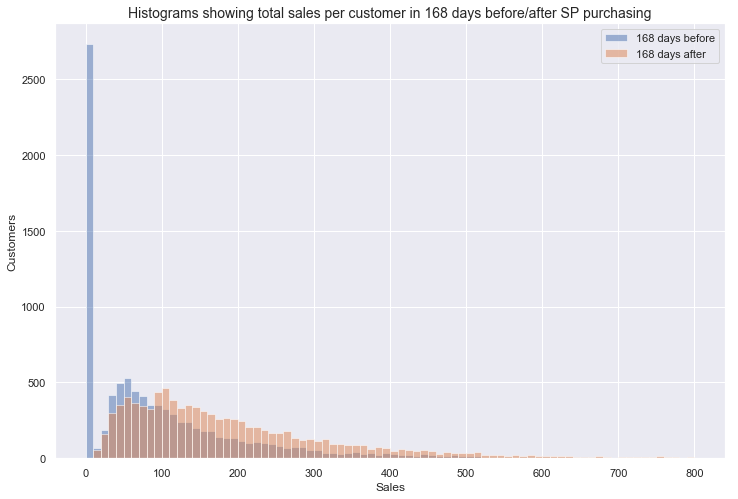

,168 days before,168 days after
count,9657.00,9657.00
mean,107.71,203.84
std,135.50,174.99
min,-2.50,-5.42
25%,0.00,93.11
50%,69.54,156.43
75%,148.95,262.61
max,1986.59,2845.53


In [80]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing total sales per customer in 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Sales')

sp_customers_168['SALES_168_BEF'].hist(bins=80, range=(0, 800), alpha=0.5)
sp_customers_168['SALES_168_AFT'].hist(bins=80, range=(0, 800), alpha=0.5)
plt.legend(['168 days before', '168 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_168['SALES_168_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_168['SALES_168_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['168 days before', '168 days after']
display(concat_df)

#### AOV

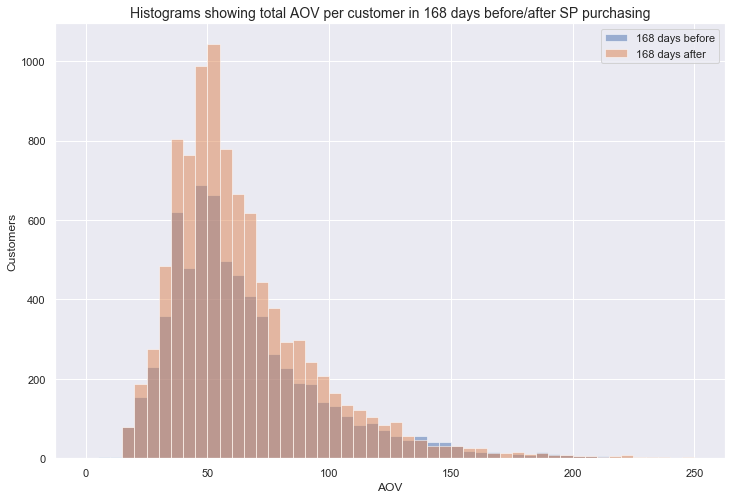

,168 days before,168 days after
count,6928.00,9657.00
mean,65.99,64.52
std,35.43,33.02
min,-2.50,-5.42
25%,42.99,43.74
50%,57.06,56.19
75%,78.92,76.20
max,391.96,427.94


In [83]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing total AOV per customer in 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

sp_customers_168['AOV_168_BEF'].hist(bins=50, range=(0, 250), alpha=0.5)
sp_customers_168['AOV_168_AFT'].hist(bins=50, range=(0, 250), alpha=0.5)
plt.legend(['168 days before', '168 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_168['AOV_168_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_168['AOV_168_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['168 days before', '168 days after']
display(concat_df)

#### Order Frequency

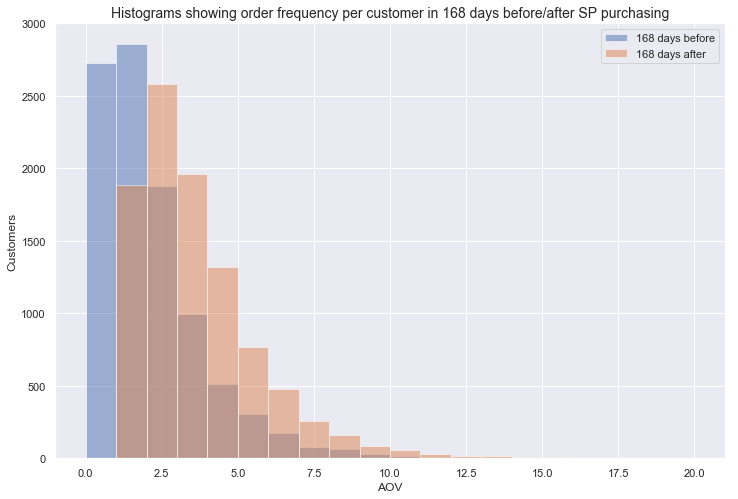

,168 days before,168 days after
count,9657.00,9657.00
mean,1.65,3.18
std,1.78,2.14
min,0.00,1.00
25%,0.00,2.00
50%,1.00,3.00
75%,2.00,4.00
max,22.00,31.00


In [187]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing order frequency per customer in 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

sp_customers_168['OF_168_BEF'].hist(bins=20, range=(0, 20), alpha=0.5)
sp_customers_168['OF_168_AFT'].hist(bins=20, range=(0, 20), alpha=0.5)
plt.legend(['168 days before', '168 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_168['OF_168_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_168['OF_168_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['168 days before', '168 days after']
display(concat_df)

#### CM1% & CM2%

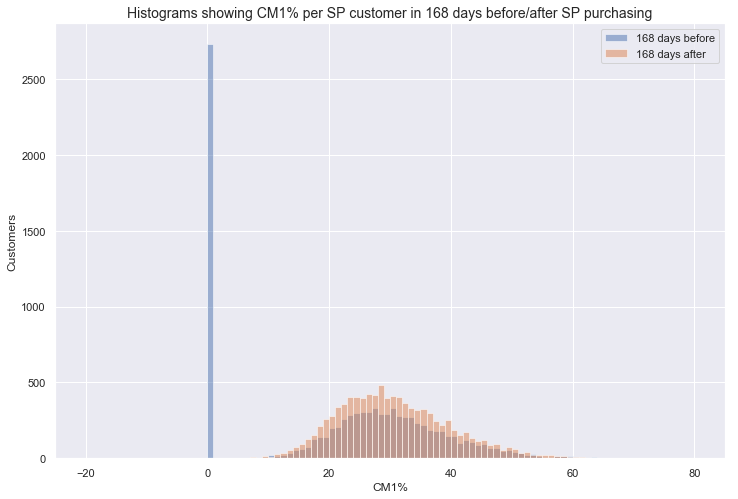

,168 days before,168 days after
count,9657.00,9657.00
mean,22.16,30.68
std,16.09,9.55
min,-4.64,-36.11
25%,0.00,23.90
50%,25.49,29.64
75%,33.59,36.35
max,100.00,111.16


In [87]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM1% per SP customer in 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM1%')

sp_customers_168['CM1%_168_BEF'].hist(bins=100, range=(-20, 80), alpha=0.5)
sp_customers_168['CM1%_168_AFT'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['168 days before', '168 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_168['CM1%_168_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_168['CM1%_168_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['168 days before', '168 days after']
display(concat_df)

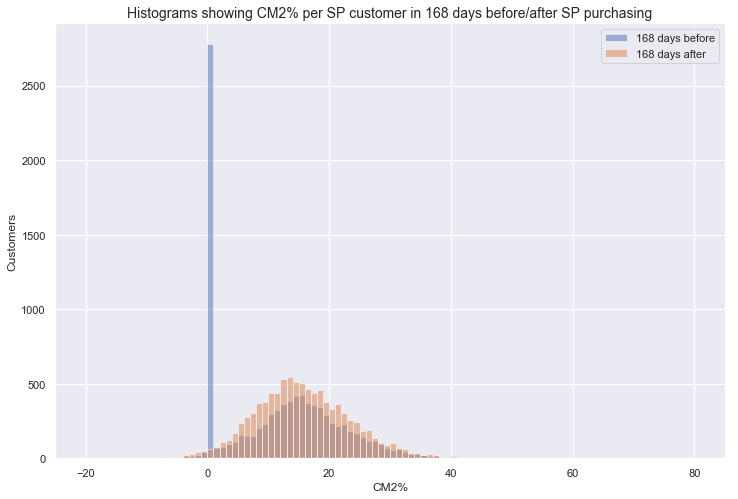

,168 days before,168 days after
count,9657.00,9657.00
mean,11.42,15.65
std,10.04,8.32
min,-50.87,-77.79
25%,0.00,10.28
50%,12.09,15.13
75%,18.39,20.73
max,100.00,118.08


In [88]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM2% per SP customer in 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM2%')

sp_customers_168['CM2%_168_BEF'].hist(bins=100, range=(-20, 80), alpha=0.5)
sp_customers_168['CM2%_168_AFT'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['168 days before', '168 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_168['CM2%_168_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_168['CM2%_168_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['168 days before', '168 days after']
display(concat_df)

#### Number of PG3s 

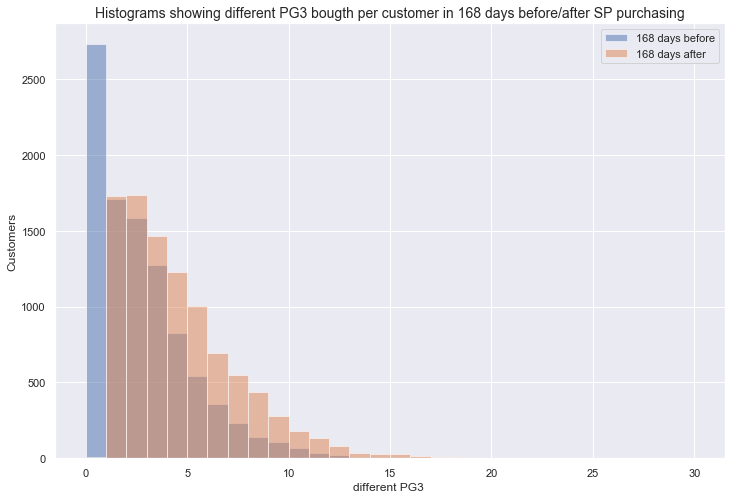

,168 days before,168 days after
count,9657.00,9657.00
mean,2.31,4.12
std,2.44,2.91
min,0.00,0.00
25%,0.00,2.00
50%,2.00,3.00
75%,3.00,6.00
max,25.00,23.00


In [92]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing different PG3 bougth per customer in 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('different PG3 ')

sp_customers_168['DIFF_PG3_168_BEF'].hist(bins=30, range=(0, 30), alpha=0.5)
sp_customers_168['DIFF_PG3_168_AFT'].hist(bins=30, range=(0, 30), alpha=0.5)
plt.legend(['168 days before', '168 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_168['DIFF_PG3_168_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_168['DIFF_PG3_168_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['168 days before', '168 days after']
display(concat_df)

#### PG3 shares and sales in each group

In [93]:
no_sp_flat_pg3_sales = [j for i in sp_customers_168['PG3_168_BEF_FLAT_SALES'].values for j in i]

In [94]:
no_sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in no_sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in no_sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [95]:
no_sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_pg3_sales if i[0] != 0}

In [96]:
no_sp_pg3_dict_sales_share = {a: np.round(b/sum(no_sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(no_sp_pg3_dict_sales_no_disc.keys(),
                                                                          no_sp_pg3_dict_sales_no_disc.values()))}

In [97]:
filter_no_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(no_sp_pg3_dict_sales_share.keys(),
                                                                no_sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [98]:
sum(filter_no_sp_pg3_dict_sales_share.values())

91.39899999999999

In [99]:
sp_flat_pg3_sales = [j for i in sp_customers_168['PG3_168_AFT_FLAT_SALES'].values for j in i]

In [100]:
sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [101]:
sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in sp_pg3_sales if i[0] != 0}

In [102]:
sp_pg3_dict_sales_share = {a: np.round(b/sum(sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(sp_pg3_dict_sales_no_disc.keys(),
                                                                          sp_pg3_dict_sales_no_disc.values()))}

In [103]:
filter_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(sp_pg3_dict_sales_share.keys(),
                                                                    sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [104]:
sum(filter_sp_pg3_dict_sales_share.values())

91.182

In [105]:
no_sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_no_sp_pg3_dict_sales_share, orient='index')
sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_sp_pg3_dict_sales_share, orient='index')

In [106]:
pg3_share_comparison = pd.concat([no_sp_cus_pg3_share_df,sp_cus_pg3_share_df], axis=1).fillna(0)
pg3_share_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_share_comparison['PG3'] = pg3_share_comparison.index.values
#pg3_share_comparison['PG3'] = pg3_share_comparison['PG3'].astype(str)
pg3_share_comparison = pg3_share_comparison[['PG3', 'NO_SP_ORD', 'SP_ORD']]

In [107]:
pg3_l = list(pg3_share_comparison['PG3'].values)

In [108]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [109]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [110]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [111]:
pg3

,PG_ID,PG_SHORTLINK
0,9,hundebett
1,15,hundeleine_hundehalsband
2,18,hundesnacks
3,20,hundespielzeug
4,23,kratzbaum_katzenbaum
5,29,katzentoilette
6,33,fressnapf
7,34,katzensnacks
8,36,katzenspielzeug
9,251,hundefutter_trockenfutter


In [112]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [113]:
pg3_share_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_share_comparison['PG3'].values]

In [114]:
pg3_share_comparison

,PG3,NO_SP_ORD,SP_ORD,PG3_NAME
9,9,1.745,2.215,hundebett
15,15,1.158,1.437,hundeleine_hundehalsband
18,18,3.919,2.842,hundesnacks
20,20,1.211,1.275,hundespielzeug
23,23,2.905,5.409,kratzbaum_katzenbaum
29,29,1.838,2.225,katzentoilette
33,33,1.195,1.592,fressnapf
34,34,1.323,1.002,katzensnacks
36,36,1.496,1.981,katzenspielzeug
251,251,25.540,21.719,hundefutter_trockenfutter


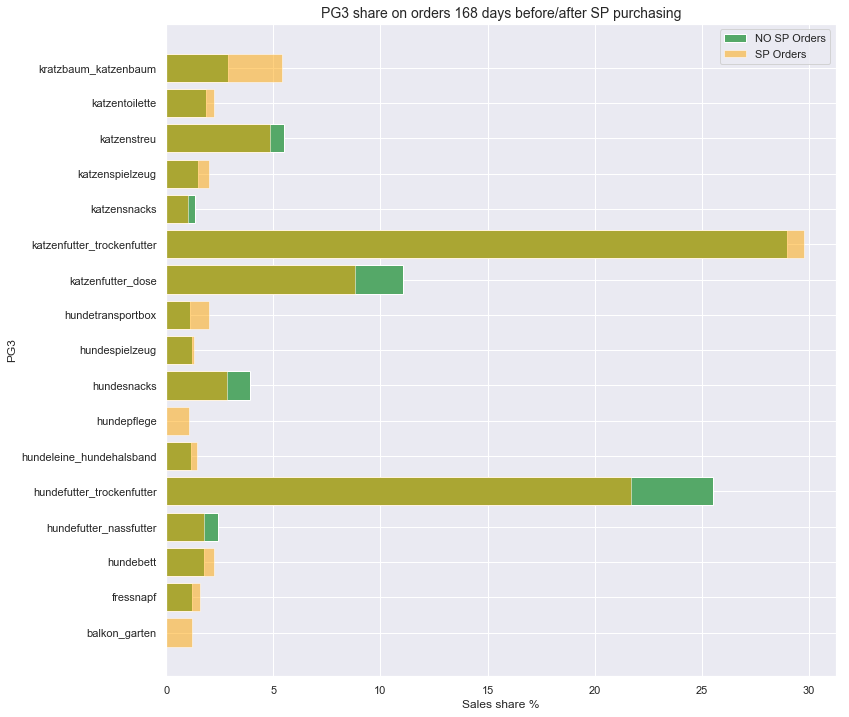

In [130]:
plt.figure(figsize=(12, 12))
x = pg3_share_comparison['PG3_NAME'].values
y = pg3_share_comparison['NO_SP_ORD'].values
z = pg3_share_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('PG3 share on orders 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('PG3')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [116]:
no_sp_cus_pg3_sales_df = pd.DataFrame.from_dict(no_sp_pg3_dict_sales_no_disc, orient='index')
sp_cus_pg3_sales_df = pd.DataFrame.from_dict(sp_pg3_dict_sales_no_disc, orient='index')

In [117]:
pg3_sales_comparison = pd.concat([no_sp_cus_pg3_sales_df, sp_cus_pg3_sales_df], axis=1).fillna(0)
pg3_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_sales_comparison['PG3'] = pg3_sales_comparison.index.values
#pg3_sales_comparison['PG3'] = pg3_sales_comparison['PG3'].astype(str)

In [118]:
pg3_lis = list(pg3_sales_comparison['PG3'].values)

In [119]:
pg3_lista = repr(pg3_lis).replace('[','(').replace(']',')')

In [120]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_lista

In [121]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [122]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [123]:
pg3_sales_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_sales_comparison['PG3'].values]

In [128]:
pg3_sales_comparison = pg3_sales_comparison[['PG3', 'PG3_NAME', 'NO_SP_ORD', 'SP_ORD']]
pg3_sales_comparison = pg3_sales_comparison[(pg3_sales_comparison['NO_SP_ORD'] >= 1000) | (pg3_sales_comparison['SP_ORD'] >= 1000)]

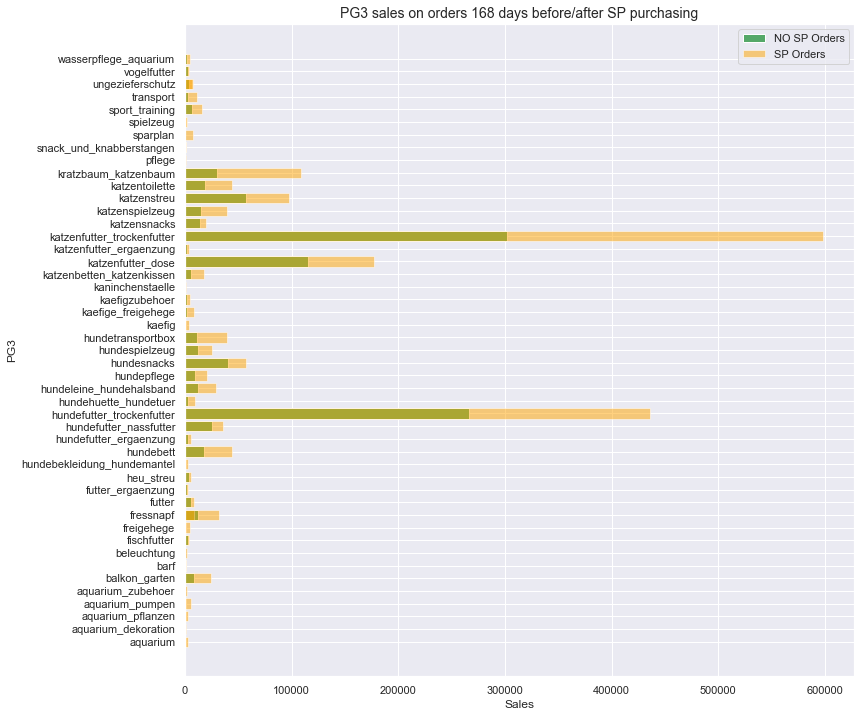

In [131]:
plt.figure(figsize=(12, 12))
x = pg3_sales_comparison['PG3_NAME'].values
y = pg3_sales_comparison['NO_SP_ORD'].values
z = pg3_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('PG3 sales on orders 168 days before/after SP purchasing', fontsize=14)
plt.ylabel('PG3')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [132]:
pg3_sales_comparison

,PG3,PG3_NAME,NO_SP_ORD,SP_ORD
9,9,hundebett,18196.63,44470.81
15,15,hundeleine_hundehalsband,12074.16,28850.96
16,16,fressnapf,3056.15,8302.98
18,18,hundesnacks,40862.38,57057.67
20,20,hundespielzeug,12627.17,25600.23
23,23,kratzbaum_katzenbaum,30292.22,108588.04
29,29,katzentoilette,19158.97,44677.28
33,33,fressnapf,12461.40,31959.26
34,34,katzensnacks,13789.66,20117.90
36,36,katzenspielzeug,15595.46,39766.53


#### Average Sales Share of Royal Canin products – 168 days orders before/after SP purchasing

In [133]:
sp_customers_168['BRAND_SALES_168_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['BRAND_AGGSALES'],
                                                                                    sp_customers_168['MASK_168_BEF']))]

In [134]:
sp_customers_168['BRAND_SALES_168_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_168['BRAND_AGGSALES'],
                                                                                    sp_customers_168['MASK_168_AFT']))]

In [135]:
sp_customers_168['BRAND_FLAT_SALES_168_BEF'] = [[k for j in i for k in j] 
                                                for i in sp_customers_168['BRAND_SALES_168_BEF'].values]

In [136]:
sp_customers_168['BRAND_FLAT_SALES_168_AFT'] = [[k for j in i for k in j] 
                                                for i in sp_customers_168['BRAND_SALES_168_AFT'].values]

In [137]:
no_sp_flat_brand_sales = [j for i in sp_customers_168['BRAND_FLAT_SALES_168_BEF'].values for j in i]

In [138]:
sp_flat_brand_sales = [j for i in sp_customers_168['BRAND_FLAT_SALES_168_AFT'].values for j in i]

In [139]:
no_sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in no_sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in no_sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [140]:
sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [141]:
no_sp_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_brand_sales if str(i[0]) != 'nan'}

In [142]:
sp_dict_sales_no_disc = {i[0]: i[1] for i in sp_brand_sales if str(i[0]) != 'nan'}

In [143]:
no_sp_dict_sales_share = {a: np.round(b/sum(no_sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(no_sp_dict_sales_no_disc.keys(),
                                             no_sp_dict_sales_no_disc.values()))}

In [144]:
sp_dict_sales_share = {a: np.round(b/sum(sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(sp_dict_sales_no_disc.keys(),
                                             sp_dict_sales_no_disc.values()))}

In [145]:
sum(no_sp_dict_sales_share.values()), sum(sp_dict_sales_share.values())

(99.98100000000014, 100.00600000000031)

In [146]:
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [147]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [148]:
brands.head()

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
0,20745,20745 - Hundesofa,Hundesofa
1,2,2 - Hund,Hund
2,1422,1422 - Spielzeug,Spielzeug
3,75,75 - Hundekissen,Hundekissen
4,2157,2157 - Alle Katzenklappen,Alle Katzenklappen


In [149]:
RC_brands = brands[brands['BRAND'].str.contains('Royal Canin')][['PPR_N_LEVEL4_ID', 'BRAND']]
RC_brands

,PPR_N_LEVEL4_ID,BRAND
185,126742,Royal Canin Dog
257,17798,Royal Canin Breed (Rasse)
274,1308,Royal Canin Club / Selection
296,9702,Royal Canin Pure Feline
444,81396,Royal Canin Veterinary Diet
449,82696,Royal Canin Veterinary Diet
477,209912,Royal Canin Vet Care Nutrition
710,127037,Royal Canin Universal
790,682,Royal Canin Size
952,94525,Royal Canin


In [150]:
no_sp_rc_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [151]:
no_sp_rc_share_dict

{'Royal Canin': 13.11,
 'Royal Canin Breed (Rasse)': 3.011,
 'Royal Canin Cat': 0.0,
 'Royal Canin Club / Selection': 0.184,
 'Royal Canin Dog': 0.003,
 'Royal Canin Pure Feline': 0.073,
 'Royal Canin Rasse (Breed)': 3.581,
 'Royal Canin Size': 3.736,
 'Royal Canin Vet Care Nutrition': 0.544,
 'Royal Canin Veterinary Diet': 8.014}

In [152]:
sp_rc_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                            sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [153]:
sp_rc_share_dict

{'Royal Canin': 14.894,
 'Royal Canin Breed (Rasse)': 2.588,
 'Royal Canin Cat': 0.003,
 'Royal Canin Club / Selection': 0.16,
 'Royal Canin Dog': 0.002,
 'Royal Canin Pure Feline': 0.074,
 'Royal Canin Rasse (Breed)': 3.84,
 'Royal Canin Size': 3.642,
 'Royal Canin Vet Care Nutrition': 0.401,
 'Royal Canin Veterinary Diet': 7.184}

In [154]:
no_sp_rc_share_df = pd.DataFrame.from_dict(no_sp_rc_share_dict, orient='index')
sp_rc_share_df = pd.DataFrame.from_dict(sp_rc_share_dict, orient='index')

In [155]:
rc_comparison = pd.concat([no_sp_rc_share_df, sp_rc_share_df], axis=1).fillna(0)
rc_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
rc_comparison['BRAND'] = rc_comparison.index.values
rc_comparison = rc_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
rc_comparison

,BRAND,NO_SP_ORD,SP_ORD
Royal Canin,Royal Canin,13.110,14.894
Royal Canin Breed (Rasse),Royal Canin Breed (Rasse),3.011,2.588
Royal Canin Cat,Royal Canin Cat,0.000,0.003
Royal Canin Club / Selection,Royal Canin Club / Selection,0.184,0.160
Royal Canin Dog,Royal Canin Dog,0.003,0.002
Royal Canin Pure Feline,Royal Canin Pure Feline,0.073,0.074
Royal Canin Rasse (Breed),Royal Canin Rasse (Breed),3.581,3.840
Royal Canin Size,Royal Canin Size,3.736,3.642
Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition,0.544,0.401
Royal Canin Veterinary Diet,Royal Canin Veterinary Diet,8.014,7.184


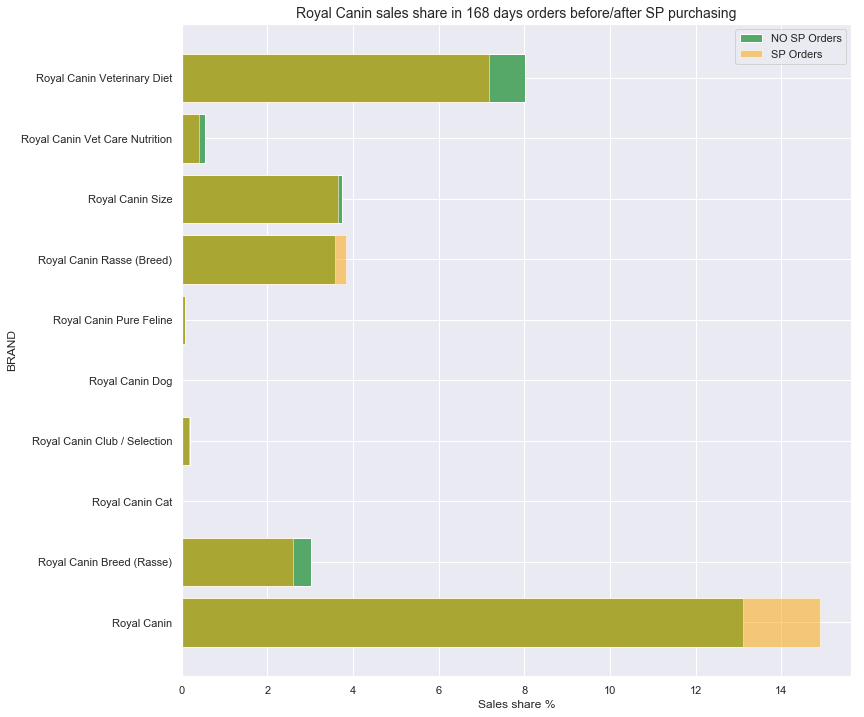

In [157]:
plt.figure(figsize=(12, 12))
x = rc_comparison['BRAND'].values
y = rc_comparison['NO_SP_ORD'].values
z = rc_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Royal Canin sales share in 168 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Average Sales Share of Hill's products – 168 days orders before/after SP purchasing

In [158]:
Hills_brands = brands[brands['BRAND'].str.contains("Hill's")][['PPR_N_LEVEL4_ID', 'BRAND']]
Hills_brands

,PPR_N_LEVEL4_ID,BRAND
13,719,Hill's Science Plan
188,84729,Hill's Prescription Diet
261,1816,Hill's Puppy & Senior
270,2058,Hill's Natures Best
295,720,Hill's Science Plan
472,151599,Hill's Prescription Diet
735,175240,Hill's Ideal Balance
736,177843,Hill's Ideal Balance
1150,31962,Hill's Prescription Diet
1381,31963,Hill's Prescription Diet


In [159]:
no_sp_hills_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [160]:
no_sp_hills_share_dict

{"Hill's Ideal Balance": 0.185,
 "Hill's Natures Best": 0.106,
 "Hill's Prescription Diet": 6.294,
 "Hill's Science Plan": 3.983,
 "Nature's Best von Hill's": 0.039}

In [161]:
sp_hills_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                                 sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [162]:
sp_hills_share_dict

{"Hill's Ideal Balance": 0.134,
 "Hill's Natures Best": 0.106,
 "Hill's Prescription Diet": 5.26,
 "Hill's Science Plan": 3.628,
 "Nature's Best von Hill's": 0.038}

In [163]:
no_sp_hills_share_df = pd.DataFrame.from_dict(no_sp_hills_share_dict, orient='index')
sp_hills_share_df = pd.DataFrame.from_dict(sp_hills_share_dict, orient='index')

In [164]:
hills_comparison = pd.concat([no_sp_hills_share_df, sp_hills_share_df], axis=1).fillna(0)
hills_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
hills_comparison['BRAND'] = hills_comparison.index.values
hills_comparison = hills_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
hills_comparison

,BRAND,NO_SP_ORD,SP_ORD
Hill's Prescription Diet,Hill's Prescription Diet,6.294,5.260
Hill's Science Plan,Hill's Science Plan,3.983,3.628
Hill's Ideal Balance,Hill's Ideal Balance,0.185,0.134
Hill's Natures Best,Hill's Natures Best,0.106,0.106
Nature's Best von Hill's,Nature's Best von Hill's,0.039,0.038


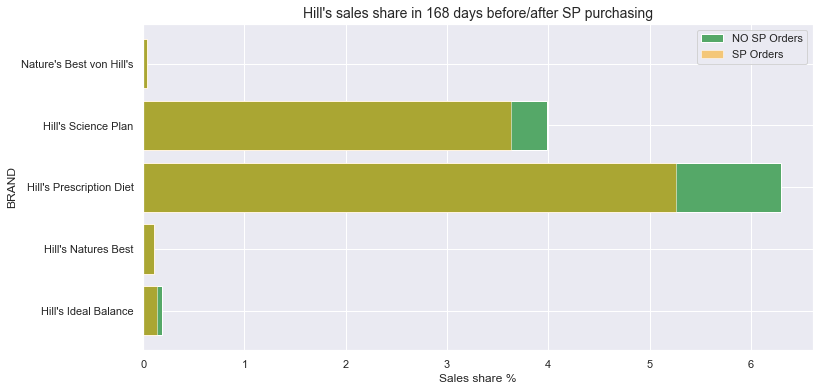

In [168]:
plt.figure(figsize=(12, 6))
x = hills_comparison['BRAND'].values
y = hills_comparison['NO_SP_ORD'].values
z = hills_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title("Hill's sales share in 168 days before/after SP purchasing", fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

##### Timedeltas

In [167]:
sp_customers_168.columns

Index(['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len', 'TDT_T_KEY_ORDER_DATE_list',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'PG3_AGGSALES', 'PG4_AGGSALES', 'BRAND_AGGSALES',
       'SP_PURCHASE', 'SP_DISC', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336',
       'O_TIMEDELTAS', 'FLAT_PG3_SALES', 'FLAT_PG4_SALES', 'FLAT_BRAND_SALES',
       'TOTAL_PG3_SALES', 'TOTAL_PG4_SALES', 'TOTAL_BRAND_SALES', 'SP_PY_POS',
       'DAYS_UNTIL_1st_SP', 'SP_ORDERS', 'NO_SP_ORDERS', 'DAYS_IN_DF',
       'DAYS_AFTER_1st_SP', 'SP_CUS', 'MASK_168_BEF', 'MASK_168_AFT',
       'SALES_168_BEF', 'SALES_168_AFT', 'CM1_168_BEF', 'CM1_168_AFT',
       'CM2_168_BEF', 'CM2_168_AFT', 'NET_SALES_168_BEF', 'NE

In [175]:
sp_customers_168.loc[17][['SP_PY_POS', 'O_TIMEDELTAS']]

SP_PY_POS                                  4
O_TIMEDELTAS    [122, 88, 179, 183, 58, 222]
Name: 17, dtype: object

In [177]:
[122, 88, 179, 183, 58, 222][3:]

[183, 58, 222]

In [178]:
sp_customers_168['TD_BEFORE_SP'] = [x[:(y-1)] for x, y in list(zip(sp_customers_168['O_TIMEDELTAS'],
                                               sp_customers_168['SP_PY_POS']))]

In [179]:
sp_customers_168['TD_AFTER_SP'] = [x[(y-1):] for x, y in list(zip(sp_customers_168['O_TIMEDELTAS'],
                                               sp_customers_168['SP_PY_POS']))]

In [180]:
td_before_sp = [j for i in sp_customers_168['TD_BEFORE_SP'].values for j in i]

In [181]:
td_after_sp = [j for i in sp_customers_168['TD_AFTER_SP'].values for j in i]

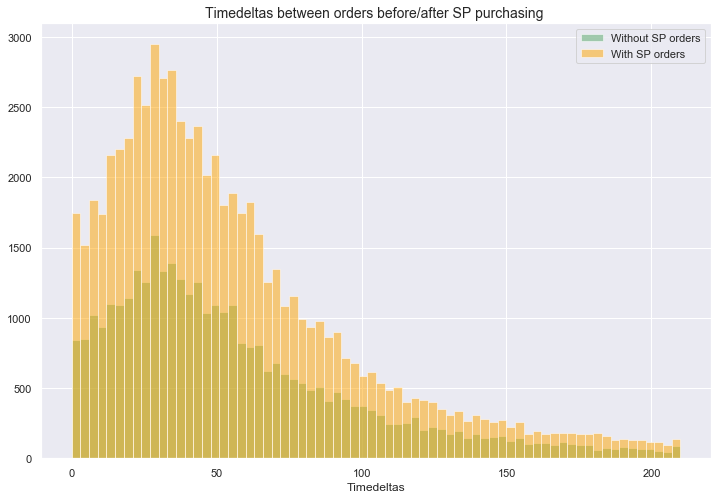

,Without SP orders,With SP orders
25%,26.00,26.00
50%,48.00,47.00
75%,85.00,82.75
count,37441.00,71578.00
max,861.00,904.00
mean,70.21,69.07
min,0.00,0.00
std,78.07,78.97


In [184]:
concat_df = pd.DataFrame()

plt.figure(figsize=(12, 8))
plt.hist(td_before_sp, bins=70, range=(0, 210), color='g', alpha=0.5)
plt.hist(td_after_sp, bins=70, range=(0, 210), color='orange', alpha=0.5)
plt.title("Timedeltas between orders before/after SP purchasing ", fontsize=14)
plt.xlabel('Timedeltas')
plt.legend(['Without SP orders', 'With SP orders'])
plt.show()

before_sp_td = pd.DataFrame(np.array(td_before_sp).reshape(len(td_before_sp), 1), columns= ['TD_BEFORE_SP'])
after_sp_td = pd.DataFrame(np.array(td_after_sp).reshape(len(td_after_sp), 1), columns= ['TD_AFTER_SP'])

concat_df = pd.concat([concat_df,
                    before_sp_td['TD_BEFORE_SP'].describe().round(2),
                    after_sp_td['TD_AFTER_SP'].describe().round(2),
                      ], axis=1)

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)